In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib.dates import DateFormatter
hh_mm = DateFormatter('%H:%M')
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.sans-serif"] = "Times New Roman"
mpl.rcParams["font.size"] = 14
import os
os.environ["OMP_NUM_THREADS"] = "1" 
viridis_colors=['#440154FF', '#414487FF', '#22A884FF', '#7AD151FF', '#FDE725FF']
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.spatial import distance
from textwrap import wrap
viridis_colors=['#440154FF', '#414487FF', '#22A884FF', '#7AD151FF', '#FDE725FF']
random_seed=111

# Screening

In [2]:

factor_dict = {
    'Fleet mix': ('BaselineFleetMix', 'AlternativeFleetMix', 'IMA_AlternativeFleetMix'),
    'Locking regime': ('NoRegime', '40_80_10', '40_80_20'),
    'Chamber priority': ('Utilization'),
    'TrafficRange': (3.5),
    'FleetIntensity': (0),
    'FlutteringProbability': (0.00, 0.015, 0.03),
    'MTTR': (0.5, 2, 3.5),
    'SlowDownEffect': (0, 1/6, 2/6),
    'MeanSlowDownCounter': (2240, 1120, 560),
    'PeriodicInspection': (7, 14, 28)
}

In [3]:
oee_description = {
    'OEE1': 'Service-based OEE Average',
    'OEE2': 'Efficiency-based OEE Average',
    'OEE3': 'Baseline OEE Average',
}

In [4]:
def read_and_merged(merged_df, base_path, file_name, xlsx_name, columns_of_interest, aggregate_with = "mean"):
    file_path = base_path + file_name + '/' + xlsx_name + '.xlsx'
    datafile =  pd.read_excel(file_path)
    if aggregate_with=="mean":
        datafile = datafile.groupby("Replication Id")[columns_of_interest].mean().reset_index()
    elif aggregate_with=="sum":
        datafile = datafile.groupby("Replication Id")[columns_of_interest].sum().reset_index()
    merged_df = pd.merge(merged_df, datafile, on=['Replication Id'], how='right')
    return merged_df

In [5]:
merged_dfs = []
run_length = 28 #days
no_chambers = 3
periodic_duration = 2 #hours

# base_path = "Data/Experiments/Screening/"

for base_path in ["Data/Experiments/Screening/"]:
    for i, fleet_mix in enumerate(["BaselineFleetMix"]): # enumerate(factor_dict['Fleet mix']):
        # for chamber_prio in factor_dict['Chamber priority']:
        for j, regime in enumerate(factor_dict['Locking regime']):
            file_name = fleet_mix + '_' + regime
            input_file_path = base_path + file_name + '/Scenario Parameters.xlsx'
            input_df =  pd.read_excel(input_file_path, index_col=0)
            no_set_per_file = len(input_df)
            input_df['FleetMix'] = fleet_mix
            input_df['LockingRegime'] = regime

            kpi_file_path = base_path + file_name + '/KPI Locks Summary.xlsx'
            kpi_df =  pd.read_excel(kpi_file_path, index_col=0)
            kpi_df['SetNo'] = 1 + (kpi_df.index -1) % no_set_per_file
            
            # Adding Emission calculation to kpi_df
            file_path = base_path + file_name + '/KPI Emissions Locks.xlsx'
            datafile =  pd.read_excel(file_path)
            datafile = datafile[datafile["Emission substance"]== "CO2"].loc[:,["Replication Id", "Emissions slowsteaming (kg/day)"]]
            kpi_df = pd.merge(kpi_df, datafile, on=['Replication Id'], how='right')

            # Merging these two dataframes
            merged_df = pd.merge(input_df, kpi_df, on=['SetNo'], how='right')

            # Adding KPI histograms
            file_path = base_path + file_name + '/KPI Locks Histogram Ships Per Leveling.xlsx'
            datafile = pd.read_excel(file_path)
            datafile = pd.pivot_table(datafile, values = 'Frequency (%)', index=['Replication Id'],
                                columns=['Bucket'], aggfunc=np.mean).reset_index()
            merged_df = pd.merge(merged_df, datafile, on=['Replication Id'], how='right')

            merged_df['Set_ReplicationId'] = 1 + (merged_df['Replication Id'] -1) // no_set_per_file
            merged_df['GlobalSetNo'] = merged_df['SetNo'] + i*no_set_per_file*(len(factor_dict['Locking regime'])) + j*no_set_per_file
            merged_dfs.append(merged_df)

experiments = pd.concat(merged_dfs)
# del(merged_dfs)
experiments.describe()

,SetNo,TrafficRange,FleetIntensity,FlutteringProbability,MTTR,SlowDownEffect,MeanSlowDownCounter,PeriodicInspection,Replication Id,Amount of ships,...,Avg ships per leveling,Avg ships per filled leveling,Emissions slowsteaming (kg/day),0,1,2,3-6,7<,Set_ReplicationId,GlobalSetNo
count,2700.000000,2700.0,2700.0,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,...,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000
mean,23.000000,3.5,0.0,0.066000,2.000000,0.133333,1456.000000,16.333333,450.500000,6870.918519,...,2.290182,2.475215,52867.932633,7.945329,30.702284,24.159179,36.076777,1.161280,10.500000,68.000000
std,12.989579,0.0,0.0,0.117214,1.224972,0.124745,672.124479,8.732151,259.855587,19.785849,...,0.722188,0.707040,86113.979662,2.026898,11.837036,6.978186,14.126101,2.434009,5.767349,38.977293
min,1.000000,3.5,0.0,0.000000,0.500000,0.000000,560.000000,7.000000,1.000000,6503.000000,...,1.845947,1.993043,22131.290276,0.667656,1.250920,2.781955,24.780702,0.000000,1.000000,1.000000
25%,12.000000,3.5,0.0,0.000000,0.500000,0.000000,1120.000000,7.000000,225.750000,6871.000000,...,1.901494,2.073583,23735.871253,7.312661,23.133966,19.775912,26.848953,0.155606,5.750000,34.000000
50%,23.000000,3.5,0.0,0.015000,2.000000,0.166667,1120.000000,14.000000,450.500000,6875.000000,...,1.934862,2.121857,24805.493809,8.503161,33.855625,28.432852,27.917368,0.227370,10.500000,68.000000
75%,34.000000,3.5,0.0,0.015000,3.500000,0.166667,2240.000000,28.000000,675.250000,6877.000000,...,2.185706,2.417597,25617.930436,9.346129,44.138499,29.736149,37.457645,0.411975,15.250000,102.000000
max,45.000000,3.5,0.0,0.300000,3.500000,0.333333,2240.000000,28.000000,900.000000,6890.000000,...,5.076866,5.126996,801446.910269,10.907945,47.637051,32.442628,83.550725,12.304251,20.000000,135.000000


In [6]:
experiments['LockCondition'] = experiments.apply(lambda x: 
                                           '0_control' if ((x['FlutteringProbability']==0) and (x['SlowDownEffect']==0))
                                           else('1_fluttering_only' if ((x['FlutteringProbability']==0.015) and (x['SlowDownEffect']==0))
                                                else '2_slowdown_only' if ((x['FlutteringProbability']==0) and (x['SlowDownEffect']!=0))
                                                else '3_both' if (x['FlutteringProbability']==0.015) else 
                                                '4_extreme' if (x['FlutteringProbability']==0.03) else 'faulty'), axis=1)

In [7]:
experiments = experiments[experiments.LockCondition != 'faulty']
len(experiments)

2160

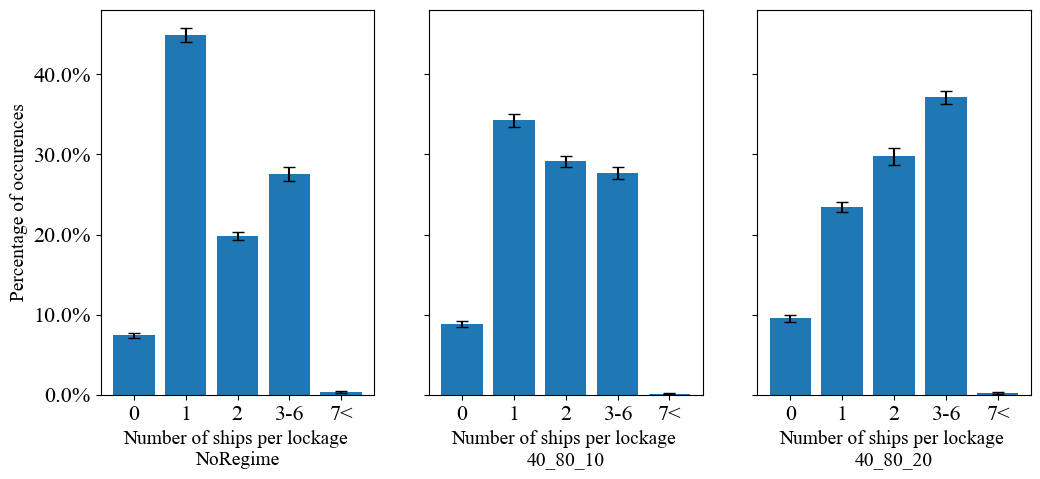

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12,5), sharey=True)

for i, locking_regime_selected in enumerate(experiments['LockingRegime'].unique()): # enumerate(['40_80_10']):
       df = experiments[(experiments['FleetMix']=='BaselineFleetMix') & (experiments['LockCondition']=='3_both') & 
              (experiments['MTTR']==2) & (experiments['PeriodicInspection']==28) & 
              (experiments['LockingRegime']==locking_regime_selected)][['0','1','2','3-6','7<']]

       ax[i].bar(x=df.columns, #x-coordinates of bars
              height=df.mean().values/100, #height of bars
              yerr=df.std().values/100, #error bar width
              capsize=4) #length of error bar caps

       # plt.hist(df['Avg ships per leveling'], weights=np.ones(len(df)) / len(df), bins = 12, color=viridis_colors[0])
       if i == 0:
              ax[i].set_ylabel("Percentage of occurences") # , fontsize=24)
       ax[i].set_xlabel("Number of ships per lockage \n" + locking_regime_selected) #, fontsize=24)
       ax[i].tick_params(labelsize=16)
       plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))

plt.show()

In [9]:
observed = pd.read_csv('output/tables/number_ship_per_lockage_hist.csv', index_col=0)
observed

,0,1,2,3-6,7<
2018,0.130116,0.302805,0.216269,0.347391,0.003419
2019,0.150399,0.300715,0.222052,0.324559,0.002275
2020,0.144421,0.321123,0.222135,0.310974,0.001347
2021,0.142484,0.310788,0.214762,0.329293,0.002673
2022,0.166745,0.326108,0.216597,0.288897,0.001652


In [10]:
def plot_hist_with_std(ax, df, locking_regime_selected, no_y_label=True, 
              only_regime_name=True, color=viridis_colors[1], err_lbl='Observed range over 20 replications'):
       
       ax.bar(x=df.columns, #x-coordinates of bars
               height=df.mean().values/100, color=color)
       ax.errorbar(x=df.columns, y=df.mean().values/100, yerr=[(df.mean() - df.min())/100, (df.max() - df.mean())/100],marker='.',fmt=' ', 
                   ms=4, capsize=4, label='\n'.join(wrap(err_lbl, 20)), elinewidth=2)
       
       # plt.hist(df['Avg ships per leveling'], weights=np.ones(len(df)) / len(df), bins = 12, color=viridis_colors[0])
       if no_y_label==False:
              ax.set_ylabel("Percentage of occurences") # , fontsize=24)
       if only_regime_name:
              ax.set_xlabel(locking_regime_selected) #, fontsize=24)
       else:
              ax.set_xlabel(locking_regime_selected + "\n Number of ships per lockage")

       ax.legend(fontsize=10,loc ="upper right")
       ax.tick_params(labelsize=16)
       plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))
       

In [11]:
def formalize_regime_name(regime_name):
    string_split = regime_name.split('_')
    formal_regime_name = string_split[0] + '% and ' + string_split[1] + '%, with ' + string_split[2] + ' minutes'
    return formal_regime_name

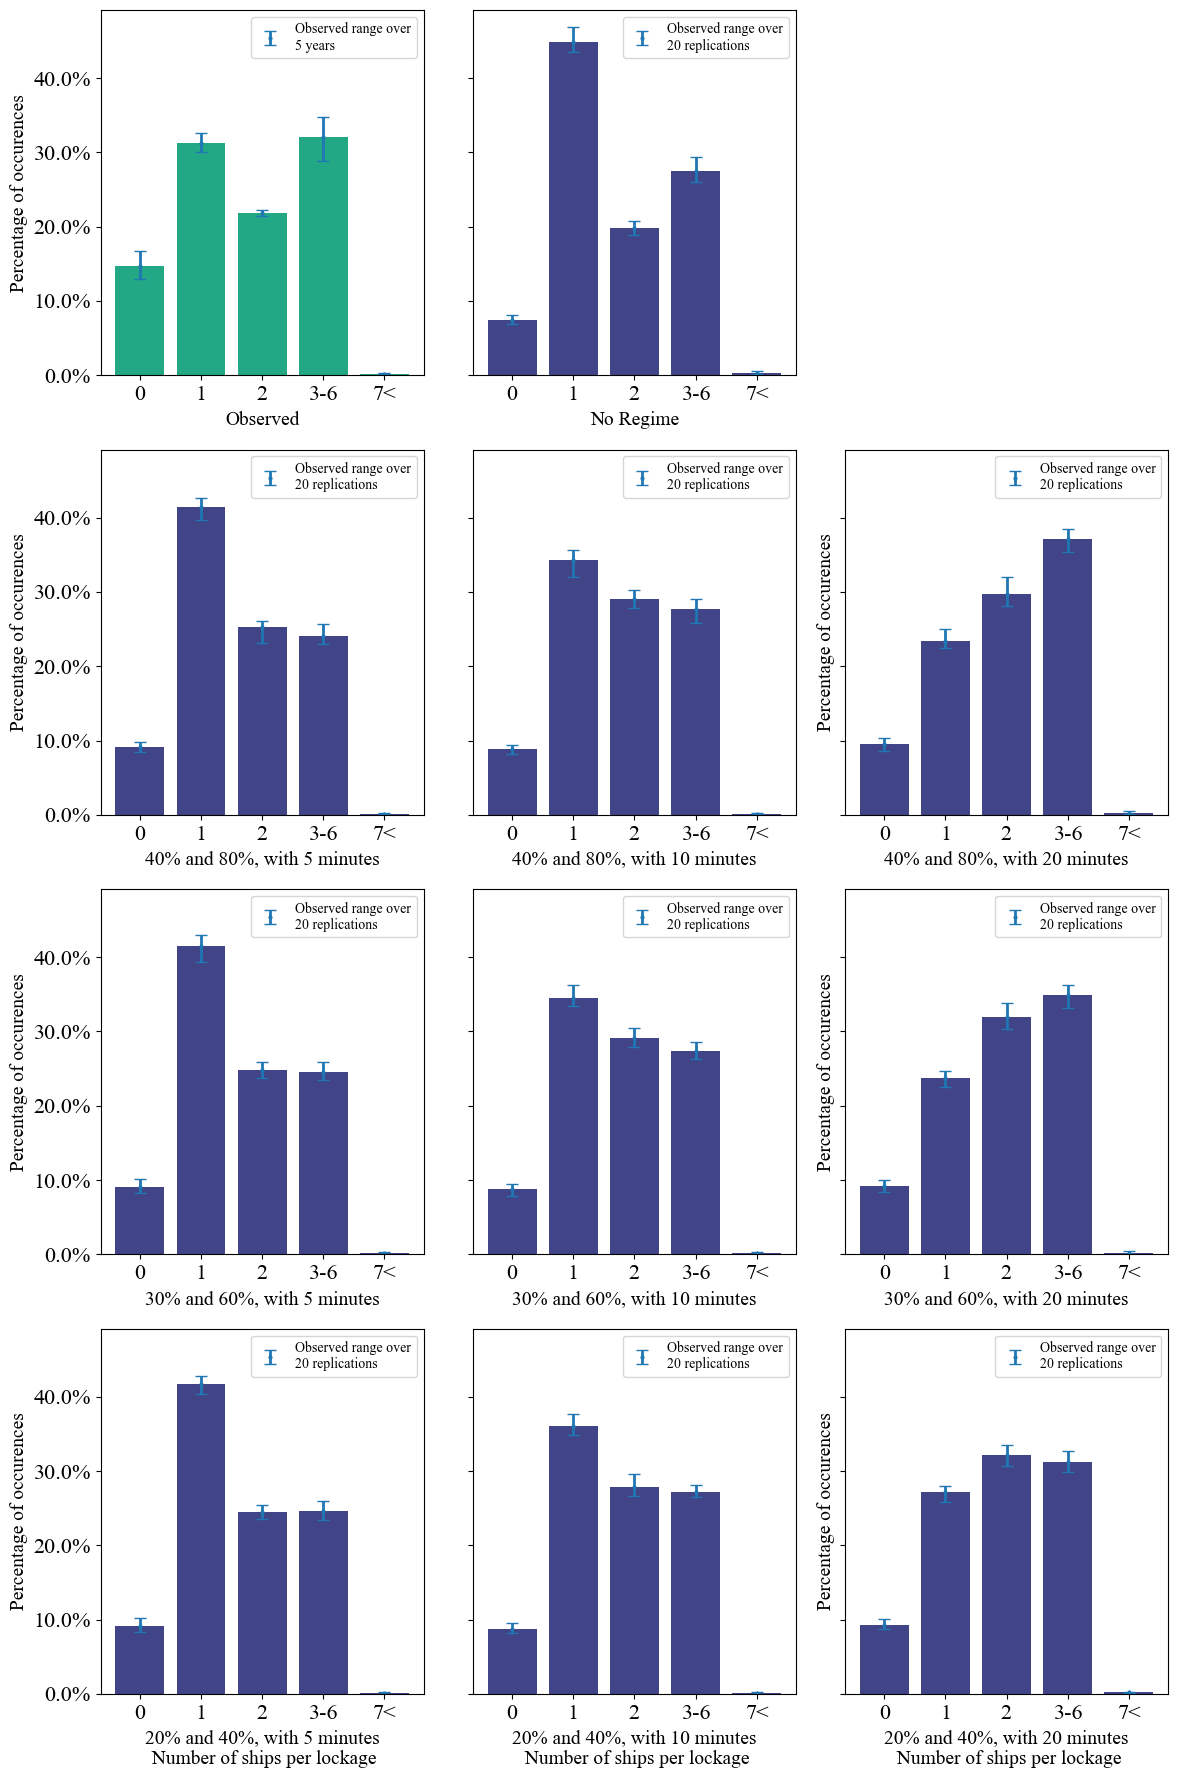

In [12]:
fig, ax = plt.subplots(4, 3, figsize=(12,18), sharey=True)
plot_hist_with_std(ax[0,0], 100*observed, 'Observed', False, color=viridis_colors[2], err_lbl='Observed range over 5 years')
hist_dfs = {}

for i, locking_regime_selected in enumerate(experiments['LockingRegime'].unique()): # 
       df = experiments[(experiments['FleetMix']=='BaselineFleetMix') & (experiments['LockCondition']=='3_both') & 
              (experiments['MTTR']==2) & (experiments['PeriodicInspection']==28) & 
              (experiments['LockingRegime']==locking_regime_selected)][['0','1','2','3-6','7<']]
       hist_dfs[locking_regime_selected] = df

base_path = "data/Experiments/Validation/Regime/"
for k, fleet_mix in enumerate(["BaselineFleetMix"]): # enumerate(factor_dict['Fleet mix']):
    # for chamber_prio in factor_dict['Chamber priority']:
    for i, locking_regime_selected in enumerate(['40_80_5', '30_60_5', '30_60_10', '30_60_20', '20_40_5', '20_40_10', '20_40_20']):
       file_name = fleet_mix + '_' + locking_regime_selected
       file_path = base_path + file_name + '/KPI Locks Histogram Ships Per Leveling.xlsx'
       df = pd.read_excel(file_path)
       df = pd.pivot_table(df, values = 'Frequency (%)', index=['Replication Id'],
                     columns=['Bucket'], aggfunc=np.mean).reset_index()[['0','1','2','3-6','7<']]
       hist_dfs[locking_regime_selected] = df


locking_regime_selected = 'NoRegime'
df = hist_dfs[locking_regime_selected]
plot_hist_with_std(ax[0,1], df, 'No Regime')
# print(locking_regime_selected + ': ' + str(distance.euclidean(observed.mean(), df.mean()/100)))

for i, locking_regime_selected in enumerate(['40_80_5', '40_80_10', '40_80_20', '30_60_5', '30_60_10', '30_60_20','20_40_5', '20_40_10', '20_40_20']):
       ax_x = 1 + (i//3)
       ax_y = i%3
       df = hist_dfs[locking_regime_selected]
       plot_hist_with_std(ax[ax_x][ax_y], df, formalize_regime_name(locking_regime_selected), ax_y%3==1, (ax_x!=3))
       # print(locking_regime_selected + ': ' + str(distance.euclidean(observed.mean(), df.mean()/100)))

for side in ['top','right','bottom','left']:
    ax[0,2].spines[side].set_visible(False)
ax[0,2].tick_params(axis='both',which='both',labelbottom=False,bottom=False,left=False)

# plt.legend()
plt.tight_layout()
plt.savefig('output/figs/output_analysis/locking_regime_histograms.pdf')
plt.show()